# Analysis of (Haber et al., 2017)

We want to re-analyze the data from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489). 
The dataset contains cell compositions of the intestinal epithelium of mice under 4 conditions
(control, Salmonella infection, H. polygyrus infection (3 days), and H. polygyrus infection (10 days)).

In the original paper, differential abundance was tested via a Poisson regression model, 
not taking compositional effects into account.
We want to analyze whether the findings are consistent with scCODA.

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.model import other_models as om

Load and format data: 

4 control samples, 2 samples for other conditions each; 8 cell types

In [2]:
cell_counts = pd.read_csv("../../scCODA/data/haber_counts.csv")

cell_counts["Condition"] = cell_counts["Mouse"].str.replace(r"_[0-9]", "")
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse", "Condition"])

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft     Condition  
0  125       191    18       Control  
1   11        40     5       C

Plot data for supplement:
Goblet cells seem like a good reference for Salmonella (not much change)
For H. Polygyrus, take TA cells

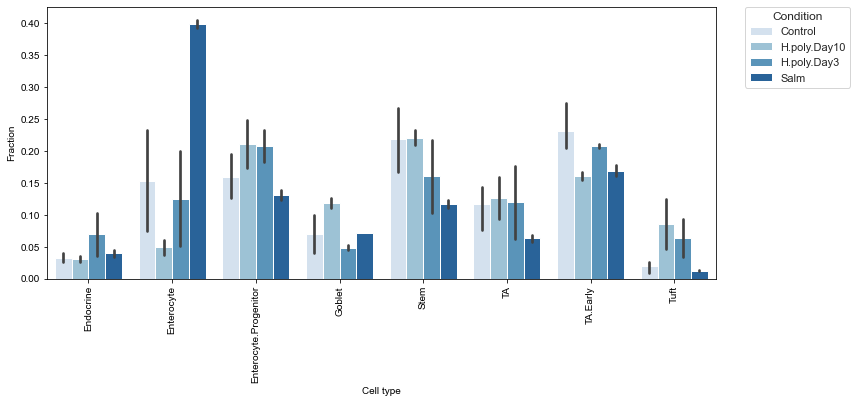

In [3]:
# Count data to ratios
counts = cell_counts.iloc[:, 1:-1]
rowsum = np.sum(counts, axis=1)

ratios = counts.div(rowsum, axis=0)
ratios["Condition"] = cell_counts["Condition"]

# Plot
fig, ax = plt.subplots(figsize=(12,5))
df = pd.melt(ratios, id_vars=['Condition'], value_vars=ratios.columns[:-1])
sns.set_context('notebook')
sns.set_style('ticks')
d = sns.barplot(x='variable', y = 'value', hue="Condition", data=df, palette="Blues")
d.set_ylabel('Fraction')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
plt.legend(bbox_to_anchor=(1.2, 1), borderaxespad=0., title="Condition")

plot_path = "../data/benchmark_results/"
# plt.savefig(plot_path + "haber_bars_blue.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "haber_bars_blue.png", format="png", bbox_inches="tight")

plt.show()

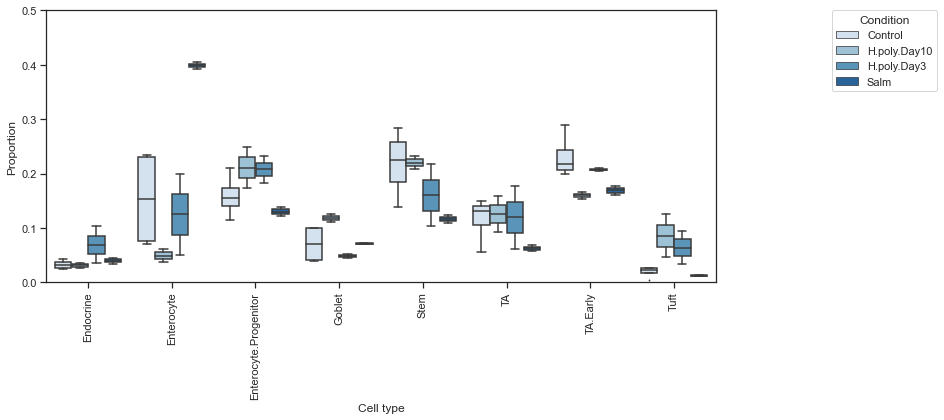

In [4]:
# Boxplots look a little better
fig, ax = plt.subplots(figsize=(12,5))
d = sns.boxplot(x='variable', y = 'value', hue=df["Condition"], data=df, fliersize=1,
               palette='Blues')

d.set_ylabel('Proportion')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
d.set_ylim([0,0.5])
plt.legend(bbox_to_anchor=(1.33, 1), borderaxespad=0., title="Condition")

# plt.savefig(plot_path + "haber_boxes_blue.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "haber_boxes_blue.png", format="png", bbox_inches="tight")

plt.show()

Apply scCODA to Salmonella (reference: Goblet cells)

--> Only Enterocytes are significant 

--> Haber et al: Enterocytes, Stem, TA, and TA (early) cells change

In [5]:
# model Salmonella
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]

model_salmonella = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="automatic")
results_salmonella = model_salmonella.sample_hmc()
results_salmonella.set_fdr(est_fdr=0.2)

Automatic reference selection! Reference cell type set to Endocrine
MCMC sampling finished. (54.327 sec)
Acceptance rate: 66.5%


In [6]:
results_salmonella.summary_extended()

Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition
Spike-and-slab threshold: 0.996

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 54.327 sec. Acceptance rate: 66.5%

Intercepts:
                       Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                        
Endocrine                        1.191   0.494    1.815  0.357   
Enterocyte                       2.346   1.759    2.969  0.325   
Enterocyte.Progenitor            2.543   1.929    3.127  0.325   
Goblet                           1.700   1.042    2.311  0.341   
Stem                             2.724   2.138    3.321  0.318   
TA                               2.134   1.512    2.767  0.337   
TA.Early                         2.879   2.309    3.478  0.314   
Tuft                             0.445  -0.274    1.174  0.393   

                       Expected Sample  
Cell Type                             

Apply scCODA to H. Polygyrus 3 days (reference: TA cells)

--> No significant changes in cell composition

--> Haber et al: Tuft cells change

In [7]:
# model H. polygyrus day 3
data_hp3 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day3"])]

model_hp3 = mod.CompositionalAnalysis(data_hp3, formula="Condition", reference_cell_type="automatic")
results_hp3 = model_hp3.sample_hmc()
results_hp3.set_fdr(est_fdr=0.2)

Automatic reference selection! Reference cell type set to TA.Early
MCMC sampling finished. (49.505 sec)
Acceptance rate: 45.1%


In [8]:
results_hp3.summary_extended()

Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 6
Formula: Condition
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 49.505 sec. Acceptance rate: 45.1%

Intercepts:
                       Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                        
Endocrine                        0.729   0.071    1.354  0.343   
Enterocyte                       1.722   1.172    2.277  0.299   
Enterocyte.Progenitor            2.051   1.474    2.613  0.296   
Goblet                           1.063   0.437    1.694  0.335   
Stem                             2.162   1.638    2.701  0.288   
TA                               1.652   1.096    2.234  0.308   
TA.Early                         2.306   1.761    2.825  0.279   
Tuft                             0.310  -0.485    0.965  0.388   

                       Expected Sample  
Cell Type                             

Apply scCODA to H. Polygyrus 10 days (reference: TA cells)

--> Enterocytes and Tuft cells are significant 

--> Haber et al: Enterocytes, Goblet, Tuft, and TA (early) cells change

In [9]:
# model H. polygyrus day 10
data_hp10 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day10"])]

model_hp10 = mod.CompositionalAnalysis(data_hp10, formula="Condition", reference_cell_type="automatic")
results_hp10 = model_hp10.sample_hmc()
results_hp10.set_fdr(est_fdr=0.2)

Automatic reference selection! Reference cell type set to Endocrine
MCMC sampling finished. (50.765 sec)
Acceptance rate: 65.3%


In [15]:
results_hp10.summary_extended()

Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 0
Formula: Condition
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 50.765 sec. Acceptance rate: 65.3%

Intercepts:
                       Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                        
Endocrine                        0.723   0.056    1.425  0.365   
Enterocyte                       1.843   1.085    2.550  0.394   
Enterocyte.Progenitor            2.230   1.641    2.877  0.331   
Goblet                           1.440   0.768    2.052  0.344   
Stem                             2.457   1.878    3.051  0.320   
TA                               1.873   1.239    2.499  0.338   
TA.Early                         2.464   1.845    3.112  0.338   
Tuft                             0.449  -0.316    1.124  0.389   

                       Expected Sample  
Cell Type                             

## Comparative analysis with *ancom*

We want to compare our findings to the results produced by applying *ancom*
[(Mandal et al., 2017)](https://pubmed.ncbi.nlm.nih.gov/26028277/) to the data.

In [11]:
salm_ancom = data_salm.copy()
salm_ancom.obs = salm_ancom.obs.rename(columns={"Condition": "x_0"})
model_salm_ancom = om.AncomModel(salm_ancom)
model_salm_ancom.fit_model(alpha=0.2)
print(model_salm_ancom.ancom_out)

(                       W  Reject null hypothesis
Endocrine              0                   False
Enterocyte             0                   False
Enterocyte.Progenitor  0                   False
Goblet                 0                   False
Stem                   0                   False
TA                     0                   False
TA.Early               0                   False
Tuft                   0                   False, Percentile              0.0     25.0    50.0    75.0    100.0  0.0     25.0   \
Group                 Control Control Control Control Control   Salm    Salm   
Endocrine                 5.0   20.75    31.0   38.25    45.0   32.0   33.25   
Enterocyte               46.0   55.75    78.5  128.75   221.0  332.0  342.25   
Enterocyte.Progenitor    23.0  107.75   162.0  190.50   198.0  113.0  113.75   
Goblet                   20.0   32.00    36.0   58.00   124.0   59.0   61.00   
Stem                     50.0  110.75   185.0  241.75   250.0   90.0   96.75 

In [12]:

hp3_ancom = data_hp3.copy()
hp3_ancom.obs = hp3_ancom.obs.rename(columns={"Condition": "x_0"})
model_hp3_ancom = om.AncomModel(hp3_ancom)
model_hp3_ancom.fit_model(alpha=0.2)
print(model_hp3_ancom.ancom_out)

(                       W  Reject null hypothesis
Endocrine              0                   False
Enterocyte             0                   False
Enterocyte.Progenitor  0                   False
Goblet                 0                   False
Stem                   0                   False
TA                     0                   False
TA.Early               0                   False
Tuft                   0                   False, Percentile              0.0     25.0    50.0    75.0    100.0       0.0    \
Group                 Control Control Control Control Control H.poly.Day3   
Endocrine                 5.0   20.75    31.0   38.25    45.0        52.0   
Enterocyte               46.0   55.75    78.5  128.75   221.0        75.0   
Enterocyte.Progenitor    23.0  107.75   162.0  190.50   198.0       115.0   
Goblet                   20.0   32.00    36.0   58.00   124.0        33.0   
Stem                     50.0  110.75   185.0  241.75   250.0        65.0   
TA                

In [13]:

hp10_ancom = data_hp10.copy()
hp10_ancom.obs = hp10_ancom.obs.rename(columns={"Condition": "x_0"})
model_hp10_ancom = om.AncomModel(hp10_ancom)
model_hp10_ancom.fit_model(alpha=0.2)
print(model_hp10_ancom.ancom_out)

(                       W  Reject null hypothesis
Endocrine              0                   False
Enterocyte             0                   False
Enterocyte.Progenitor  0                   False
Goblet                 0                   False
Stem                   0                   False
TA                     0                   False
TA.Early               0                   False
Tuft                   0                   False, Percentile              0.0     25.0    50.0    75.0    100.0        0.0    \
Group                 Control Control Control Control Control H.poly.Day10   
Endocrine                 5.0   20.75    31.0   38.25    45.0         40.0   
Enterocyte               46.0   55.75    78.5  128.75   221.0         57.0   
Enterocyte.Progenitor    23.0  107.75   162.0  190.50   198.0        203.0   
Goblet                   20.0   32.00    36.0   58.00   124.0        147.0   
Stem                     50.0  110.75   185.0  241.75   250.0        271.0   
TA         

In [14]:
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]

model_ancom = om.AncomModel(data_salm, covariate_column="Condition")
model_ancom.fit_model(alpha=0.2)
print(model_ancom.ancom_out)

Trying to set attribute `.X` of view, copying.


(                       W  Reject null hypothesis
Endocrine              0                   False
Enterocyte             0                   False
Enterocyte.Progenitor  0                   False
Goblet                 0                   False
Stem                   0                   False
TA                     0                   False
TA.Early               0                   False
Tuft                   0                   False, Percentile              0.0     25.0    50.0    75.0    100.0  0.0     25.0   \
Group                 Control Control Control Control Control   Salm    Salm   
Endocrine                 5.0   20.75    31.0   38.25    45.0   32.0   33.25   
Enterocyte               46.0   55.75    78.5  128.75   221.0  332.0  342.25   
Enterocyte.Progenitor    23.0  107.75   162.0  190.50   198.0  113.0  113.75   
Goblet                   20.0   32.00    36.0   58.00   124.0   59.0   61.00   
Stem                     50.0  110.75   185.0  241.75   250.0   90.0   96.75 